# Telecom X — Churn de Clientes

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [14]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
ruta_datos = '/content/drive/MyDrive/Challenge_TelecomX_1/TelecomX_Data.json'

#Cargo los datos en un dataframe
datos = pd.read_json(ruta_datos)

#Dimensiones del df
print('shape:', datos.shape)

#Previsualización
datos.head()

shape: (7267, 6)


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


##Exploración rápida de estructura (raw)
El JSON viene con columnas anidadas (`customer`, `phone`, `internet`, `account`).
Para poder analizar, lo transformo a una tabla rectangular (flatten).

In [16]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


Uso `pd.json_normalize` para convertir diccionarios por fila en columnas.
Luego uno todo por columnas con `pd.concat(axis=1)`.

In [17]:
#Hago una copia de dataframe original
df = datos.copy()

#normalizo las columnas con información anidada y les añado un prefijo para distinguirlas mejor
customer_norm = pd.json_normalize(df['customer']).add_prefix('customer.')
phone_norm = pd.json_normalize(df['phone']).add_prefix('phone.')
internet_norm = pd.json_normalize(df['internet']).add_prefix('internet.')
account_norm = pd.json_normalize(df['account']).add_prefix('account.')

#Concateno los dataframes planos en uno solo con concat()
df_flat = pd.concat([
    df[['customerID', 'Churn']],
    customer_norm,
    phone_norm,
    internet_norm,
    account_norm
], axis=1)

#Previsualizo el nuevo dataframe
print('shape:', df_flat.shape)
df_flat.head()

shape: (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [18]:
#Exploro los tipos de datos del nuevo dataframe
#Veo que aunque algunos ya tiene un tipo de dato adecuado (como customer.SeniorCitizen, o account.Charges.Monthly) hay varios que no
#Todos los numéricos parecen estar bien, menos account.Charges.Total
df_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

##Verificación de calidad de datos (Data Quality)
Checklist mínimo que reviso:
- Duplicados (filas e IDs)
- Faltantes (NaN y strings vacías)
- Tipos de datos (especialmente variables numéricas)
- Categorías inconsistentes (espacios, variantes, etc.)

In [19]:
#Duplicados
print('Duplicados:', df_flat.duplicated().sum())
print('Duplicados customerID:', df_flat['customerID'].duplicated().sum())

Duplicados: 0
Duplicados customerID: 0


In [20]:
#Datos faltantes (NaN)
df_flat.isna().sum()

,0
customerID,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [21]:
#Faltantes disfrazados como string vacío ''
#Veo que si hay datos faltantes en Churn y account.Charges.Total a pesar de no haberse marcado como Nan
#Sucede que son valores vacios pero con un string vacio ''
missing_str = (df_flat.astype(str).apply(lambda s: s.str.strip().eq('')).sum().sort_values(ascending=False))
missing_str.head(10)

,0
Churn,224
account.Charges.Total,11
customerID,0
customer.SeniorCitizen,0
customer.gender,0
customer.Partner,0
customer.Dependents,0
phone.PhoneService,0
customer.tenure,0
internet.InternetService,0


In [22]:
#Chequeo de categorías
cols_cat = [
    'Churn',
    'customer.gender',
    'internet.InternetService',
    'account.Contract',
    'account.PaymentMethod'
]

for c in cols_cat:
    print('\n===', c, '===')
    print(df_flat[c].value_counts(dropna=False).head(20))


=== Churn ===
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

=== customer.gender ===
customer.gender
Male      3675
Female    3592
Name: count, dtype: int64

=== internet.InternetService ===
internet.InternetService
Fiber optic    3198
DSL            2488
No             1581
Name: count, dtype: int64

=== account.Contract ===
account.Contract
Month-to-month    4005
Two year          1743
One year          1519
Name: count, dtype: int64

=== account.PaymentMethod ===
account.PaymentMethod
Electronic check             2445
Mailed check                 1665
Bank transfer (automatic)    1589
Credit card (automatic)      1568
Name: count, dtype: int64


##Limpieza / Transformación
Acciones tomadas:
1) Convertir strings vacías de `Churn` a NaN.
2) Convertir `account.Charges.Total` a numérico.
3) Eliminar filas con `Churn` NaN (variable objetivo).

`Charges.Total` suele venir como texto por vacíos o formato, uso `to_numeric(errors='coerce')`.

In [23]:
# Normaliza vacíos en variables críticas
df_flat['Churn'] = df_flat['Churn'].replace(r'^\s*$', np.nan, regex=True)

# Charges.Total puede venir como str con vacíos
col_total = 'account.Charges.Total'
df_flat[col_total] = df_flat[col_total].replace(r'^\s*$', np.nan, regex=True)

# Convierte a número
df_flat[col_total] = pd.to_numeric(df_flat[col_total], errors='coerce')

# Elimina filas sin Churn (no sirven para análisis/modelo)
df_clean = df_flat.dropna(subset=['Churn', col_total]).copy()

print('df_flat:', df_flat.shape)
print('df_clean:', df_clean.shape)

df_clean[['Churn', col_total]].isna().sum()

df_flat: (7267, 21)
df_clean: (7032, 21)


,0
Churn,0
account.Charges.Total,0


##Verificación final
Confirmo que:
- `Charges.Total` es numérico
- No hay strings vacías en variables críticas
- No hay duplicados por `customerID`

In [24]:
print('dtype Charges.Total:', df_clean['account.Charges.Total'].dtype)
print('strings vacías en Charges.Total:', (df_clean['account.Charges.Total'].astype(str).str.strip().eq('')).sum())
print('NaN en Charges.Total:', df_clean['account.Charges.Total'].isna().sum())
print('Duplicados customerID:', df_clean['customerID'].duplicated().sum())

dtype Charges.Total: float64
strings vacías en Charges.Total: 0
NaN en Charges.Total: 0
Duplicados customerID: 0


##Sección Opcional
###Columna de cuentas diarias
Cálculo del valor diario
- NO usaré el total mensual, usaré el valor total y el valor `tenure` para realizar un cáculo aproximado

In [25]:
#dias por mes
dias_por_mes = 30.4

df_clean['Daily_Value_Historical'] = df_clean['account.Charges.Monthly'] /  dias_por_mes

#df_clean['Daily_Value_Historical'] = df_clean['account.Charges.Total'] / (df_clean['customer.tenure'] * dias_por_mes)

In [26]:
df_clean['Daily_Value_Historical'].head(10)

,Daily_Value_Historical
0,2.157895
1,1.970395
2,2.430921
3,3.223684
4,2.759868
5,2.282895
6,3.608553
7,2.784539
8,1.585526
9,2.975329


##Sección Opcional
###Estandarización y transformación de datos

In [27]:
with pd.option_context('display.max_columns', None):
  display(df_clean.head(10))

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,Daily_Value_Historical
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.30,2.157895
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.40,1.970395
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90,280.85,2.430921
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00,1237.85,3.223684
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90,267.40,2.759868
5,0013-MHZWF,No,Female,0,No,Yes,9,Yes,No,DSL,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),69.40,571.45,2.282895
6,0013-SMEOE,No,Female,1,Yes,No,71,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.70,7904.25,3.608553
7,0014-BMAQU,No,Male,0,Yes,No,63,Yes,Yes,Fiber optic,Yes,No,No,Yes,No,No,Two year,Yes,Credit card (automatic),84.65,5377.80,2.784539
8,0015-UOCOJ,No,Female,1,No,No,7,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,48.20,340.35,1.585526
9,0016-QLJIS,No,Female,0,Yes,Yes,65,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check,90.45,5957.90,2.975329


In [35]:
columnas_a_transformar = ['Churn', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.PaperlessBilling']

df_clean[columnas_a_transformar] = df_clean[columnas_a_transformar].replace({"Yes": 1, "No":0})

In [36]:
with pd.option_context('display.max_columns', None):
  display(df_clean.head(10))

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,Daily_Value_Historical
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.60,593.30,2.157895
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.90,542.40,1.970395
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.90,280.85,2.430921
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.00,1237.85,3.223684
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.90,267.40,2.759868
5,0013-MHZWF,0,Female,0,0,1,9,1,0,DSL,0,0,0,1,1,1,Month-to-month,1,Credit card (automatic),69.40,571.45,2.282895
6,0013-SMEOE,0,Female,1,1,0,71,1,0,Fiber optic,1,1,1,1,1,1,Two year,1,Bank transfer (automatic),109.70,7904.25,3.608553
7,0014-BMAQU,0,Male,0,1,0,63,1,1,Fiber optic,1,0,0,1,0,0,Two year,1,Credit card (automatic),84.65,5377.80,2.784539
8,0015-UOCOJ,0,Female,1,0,0,7,1,0,DSL,1,0,0,0,0,0,Month-to-month,1,Electronic check,48.20,340.35,1.585526
9,0016-QLJIS,0,Female,0,1,1,65,1,1,DSL,1,1,1,1,1,1,Two year,1,Mailed check,90.45,5957.90,2.975329


In [28]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7032 non-null   object 
 1   Churn                      7032 non-null   object 
 2   customer.gender            7032 non-null   object 
 3   customer.SeniorCitizen     7032 non-null   int64  
 4   customer.Partner           7032 non-null   object 
 5   customer.Dependents        7032 non-null   object 
 6   customer.tenure            7032 non-null   int64  
 7   phone.PhoneService         7032 non-null   object 
 8   phone.MultipleLines        7032 non-null   object 
 9   internet.InternetService   7032 non-null   object 
 10  internet.OnlineSecurity    7032 non-null   object 
 11  internet.OnlineBackup      7032 non-null   object 
 12  internet.DeviceProtection  7032 non-null   object 
 13  internet.TechSupport       7032 non-null   object 
 1

#Análisis Descriptivo
##Descripción

Para comenzar, realiza un análisis descriptivo de los datos, calculando métricas como media, mediana, desviación estándar y otras medidas que ayuden a comprender mejor la distribución y el comportamiento de los clientes

In [39]:
#Describe general
df_clean.describe().round(2)

,Churn,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total,Daily_Value_Historical
count,7032.00,7032.00,7032.00,7032.00,7032.00,7032.0,7032.00,7032.00,7032.00,7032.00
mean,0.27,0.16,0.48,0.30,32.42,0.9,0.59,64.80,2283.30,2.13
std,0.44,0.37,0.50,0.46,24.55,0.3,0.49,30.09,2266.77,0.99
min,0.00,0.00,0.00,0.00,1.00,0.0,0.00,18.25,18.80,0.60
25%,0.00,0.00,0.00,0.00,9.00,1.0,0.00,35.59,401.45,1.17
50%,0.00,0.00,0.00,0.00,29.00,1.0,1.00,70.35,1397.48,2.31
75%,1.00,0.00,1.00,1.00,55.00,1.0,1.00,89.86,3794.74,2.96
max,1.00,1.00,1.00,1.00,72.00,1.0,1.00,118.75,8684.80,3.91


In [42]:
#Describe numérico general
num_cols = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']

df_clean[num_cols].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
customer.tenure,7032.0,32.42,24.55,1.00,9.00,29.00,55.00,72.00
account.Charges.Monthly,7032.0,64.80,30.09,18.25,35.59,70.35,89.86,118.75
account.Charges.Total,7032.0,2283.30,2266.77,18.80,401.45,1397.48,3794.74,8684.80


In [43]:
#Describe por Churn
df_clean.groupby('Churn')[num_cols].agg(['mean', 'median', 'std']).round(2)

customer.tenure               account.Charges.Monthly                \
                 mean median    std                    mean median    std   
Churn                                                                       
0               37.65   38.0  24.08                   61.31  64.45  31.09   
1               17.98   10.0  19.53                   74.44  79.65  24.67   

      account.Charges.Total                    
                       mean   median      std  
Churn                                          
0                   2555.34  1683.60  2329.46  
1                   1531.80   703.55  1890.82

In [44]:
df_clean['Churn'].value_counts()

,count
Churn,
0,5163
1,1869


###Nota:
Se codificó Churn como variable binaria (0=No, 1=Yes) para facilitar el análisis.

###Observaciones
- Los clientes que se van tienen una antigüedad mucho menor. La mediana cae de 38 a 10 meses, sugiriendo que el riesgo de churn es mayor en los primeros meses.
- Los clientes que se van tienden a pagar más por mes (aprox. +13 USD en promedio), lo que sugiere sensibilidad al precio o que planes más caros están asociados a mayor cancelación.

##

#Distribución de Evasión
##Descripción
En este paso, el objetivo es comprender cómo está distribuida la variable "churn" (evasión) entre los clientes. Utiliza gráficos para visualizar la proporción de clientes que permanecieron y los que se dieron de baja.

In [58]:
churn_counts = df_clean['Churn'].value_counts().sort_index()

churn_percent = df_clean['Churn'].value_counts(normalize=True).sort_index() * 100

display(churn_counts)
display(churn_percent.round(2))

,count
Churn,
0,5163
1,1869


,proportion
Churn,
0,73.42
1,26.58


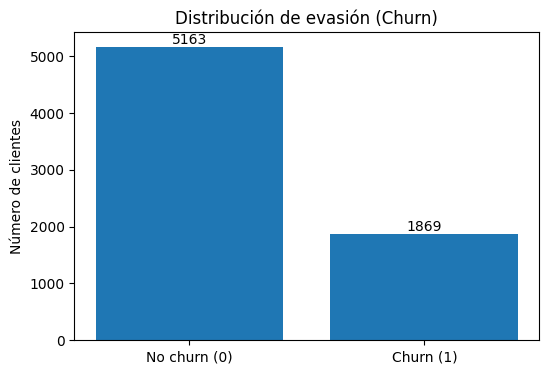

In [66]:
labels = ['No churn (0)', 'Churn (1)']
values = churn_counts.values

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)
plt.title('Distribución de evasión (Churn)')
plt.ylabel('Número de clientes')

# etiquetas
for b, v in zip(bars, values):
    plt.text(b.get_x() + b.get_width()/2, v, f'{v}', ha='center', va='bottom')

plt.show()

La variable objetivo (Churn) presenta una distribución desbalanceada: aproximadamente 73.42% de los clientes permanecen y 26.58% cancelan el servicio.”

#Recuento de evasión por variables categóricas
##Descripción

Ahora, exploraremos cómo se distribuye la evasión según variables categóricas, como género, tipo de contrato, método de pago, entre otras.

Este análisis puede revelar patrones interesantes, por ejemplo, si los clientes de ciertos perfiles tienen una mayor tendencia a cancelar el servicio, lo que ayudará a orientar acciones estratégicas.

He creado una función para evitar repetir código

In [81]:
def plot_churn_rate(df, col):
    tab = churn_rate_table(df, col)
    plt.figure(figsize=(7,4))
    plt.bar(tab.index.astype(str), tab['churn_rate'])
    plt.title(f'Tasa de churn por {col}')
    plt.ylabel('% Churn (1)')
    plt.xticks(rotation=30, ha='right')
    plt.show()
    return tab


 account.Contract


,count,churn_rate
account.Contract,,
Month-to-month,3875,42.71
One year,1472,11.28
Two year,1685,2.85


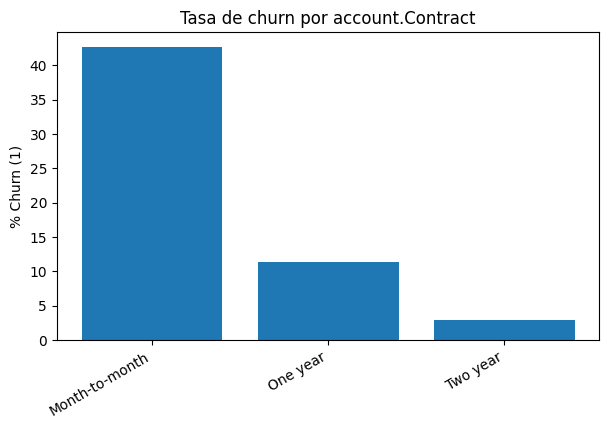


 internet.InternetService


,count,churn_rate
internet.InternetService,,
Fiber optic,3096,41.89
DSL,2416,19.00
No,1520,7.43


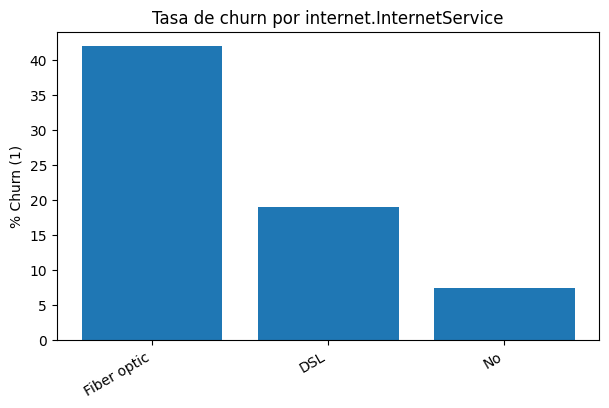


 account.PaymentMethod


,count,churn_rate
account.PaymentMethod,,
Electronic check,2365,45.29
Mailed check,1604,19.20
Bank transfer (automatic),1542,16.73
Credit card (automatic),1521,15.25


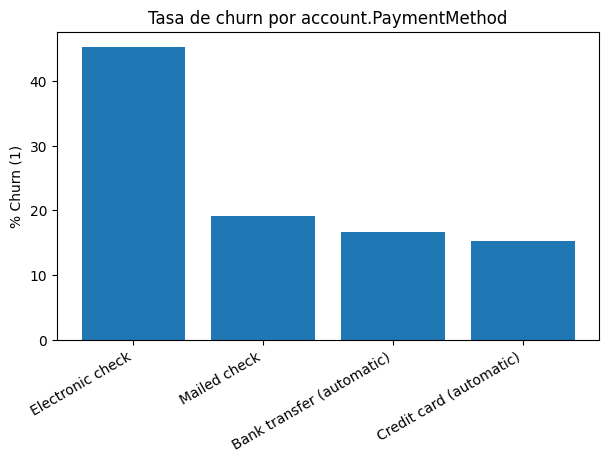


 internet.TechSupport


,count,churn_rate
internet.TechSupport,,
0,3472,41.65
1,2040,15.20
No internet service,1520,7.43


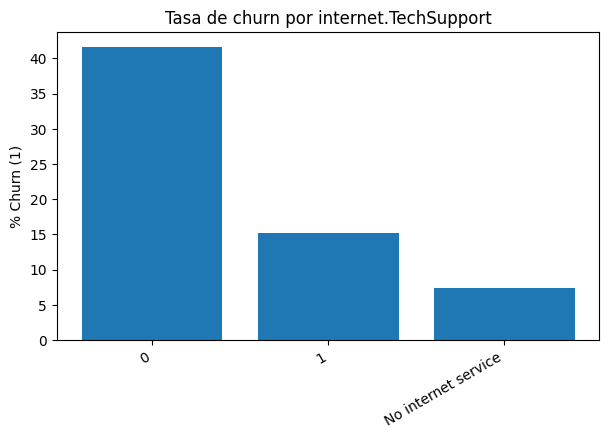

In [82]:
for c in ['account.Contract', 'internet.InternetService', 'account.PaymentMethod', 'internet.TechSupport']:
    print("\n", c)
    display(churn_rate_table(df_clean, c))
    plot_churn_rate(df_clean, c)

###Observaciones
- Tipo de contrato es una de las variables más asociadas al churn. Los clientes con contrato Month-to-month presentan una tasa de evasión de 42.71%, muy superior a One year (11.28%) y Two year (2.85%), lo que sugiere que incrementar la adopción de contratos de mayor duración puede reducir significativamente la evasión.
- Los clientes con Fiber optic presentan una tasa de churn (~42%) muy superior a DSL (~19%) y a quienes no tienen internet (~7%).
- El método Electronic check tiene una tasa de churn (~45%) muy superior a métodos automáticos (~15–17%).
- Los clientes sin TechSupport tienen churn muy alto (~42%). Con TechSupport baja a ~15% (Es powsible que a los clientes no les agrade este pago adicional por soporte técnico 'más rápido').

#Conteo de evasión por variables numéricas
##Descripción

En este paso, explora cómo las variables numéricas, como "total gastado" o "tiempo de contrato", se distribuyen entre los clientes que cancelaron (evasión) y los que no cancelaron.

Este análisis ayuda a entender si ciertos valores numéricos están más asociados con la evasión, proporcionando insights sobre los factores que influyen en el comportamiento de los clientes.

In [84]:
#Variables numéricas que importan aquí
num_cols = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']

Resumen por Churn

In [85]:
df_flat.groupby('Churn')[num_cols].agg(['count', 'mean', 'median', 'std']).round(2)

customer.tenure                      account.Charges.Monthly         \
                count   mean median    std                   count   mean   
Churn                                                                       
No               5174  37.57   38.0  24.11                    5174  61.27   
Yes              1869  17.98   10.0  19.53                    1869  74.44   

                    account.Charges.Total                             
      median    std                 count     mean   median      std  
Churn                                                                 
No     64.43  31.09                  5163  2555.34  1683.60  2329.46  
Yes    79.65  24.67                  1869  1531.80   703.55  1890.82

In [90]:
def plot_all_boxplots(df, cols):
    # Calculamos cuántas filas necesitamos para 3 columnas
    n_cols = 3
    n_rows = math.ceil(len(cols) / n_cols)

    # Creamos la figura general
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() # Aplanamos para iterar fácilmente

    for i, col in enumerate(cols):
        sns.boxplot(ax=axes[i], x='Churn', y=col, data=df)
        axes[i].set_title(f'Distribución de {col}')
        axes[i].set_xlabel('Churn')
        axes[i].set_ylabel('Valor')

    # Eliminamos los ejes sobrantes si el número de variables no es múltiplo de 3
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

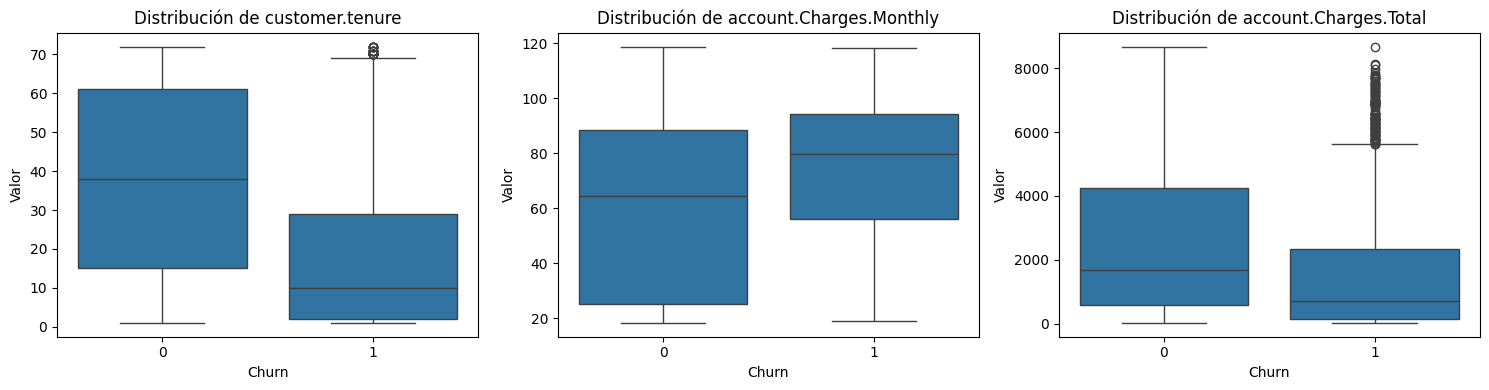

In [91]:
plot_all_boxplots(df_clean, num_cols)

###Observaciones
- Los clientes que cancelan tienden a tener mucho menor antigüedad. La mediana de tenure en churn=1 es considerablemente menor que en churn=0, lo que indica que el riesgo de evasión es mayor en los primeros meses.
- Los clientes que cancelan presentan cargos mensuales más altos (mediana mayor), lo que sugiere posible relación entre precio/plan y evasión.
- El total gastado es menor en los clientes que cancelan, lo cual es consistente con que tienen menor tenure (llevan menos tiempo pagando).

#Informe Final

## 1. Introducción

Telecom X enfrenta una alta tasa de cancelación de clientes (*churn*), lo que impacta directamente en ingresos y estabilidad del negocio.  
El objetivo de este análisis es comprender qué factores están asociados a la evasión, a partir de datos demográficos, servicios contratados, tipo de contrato y comportamiento de pago.

Este notebook aplica un flujo de trabajo de ETL + Análisis Exploratorio para:
- preparar los datos para análisis/modelado,
- identificar patrones de churn,
- y generar insights y recomendaciones accionables para reducir la evasión.

**Variable objetivo:** `Churn` (0 = No canceló, 1 = Canceló).

##2. Limpieza y Tratamiento de Datos (ETL)

### 2.1 Extracción
- Los datos fueron obtenidos desde una fuente en formato JSON.
- Se cargaron en un DataFrame para su manipulación con Pandas.

### 2.2 Transformación
Debido a que el JSON contenía información anidada (por ejemplo: `customer`, `phone`, `internet`, `account`), se realizó un aplanamiento (flatten) para convertir diccionarios internos en columnas tabulares mediante `json_normalize`.

Adicionalmente se aplicaron:
- **Normalización de nombres de columnas**: se eliminaron espacios ocultos en nombres como `customer. gender` -> `customer.gender`.
- **Detección de valores faltantes “disfrazados”**: se identificaron campos vacíos como strings (`''`) que no aparecen con `isna()`.
- **Conversión de tipos de datos**:  
  - `account.Charges.Total` se encontraba como texto y fue convertido a numérico (`float`), asegurando consistencia.

### 2.3 Tratamiento de valores faltantes
- Se detectaron registros con `Churn` vacío (string vacío) que luego se convirtieron a `NaN`.
- Como `Churn` es la variable objetivo, se eliminaron esas filas para evitar sesgos e inconsistencias.
- El dataset final quedó con 7043 registros y 21 columnas (valores consistentes con el dataset).

### 2.4 Validaciones
- Se verificó la ausencia de duplicados por `customerID`.
- Se revisaron categorías de variables cualitativas para evitar inconsistencias.

## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Distribución de Churn
Se analizó la proporción global de clientes que cancelaron (Churn=1) vs. los que permanecieron (Churn=0) mediante conteos y gráficos de barras.

### 3.2 Variables categóricas
Se evaluó la tasa de churn por categoría (no solo conteos) para identificar segmentos con mayor riesgo de cancelación.

Principales hallazgos:
- **Tipo de contrato (`account.Contract`)**: el churn es significativamente mayor en clientes Month-to-month en comparación con contratos de 1 o 2 años.
- **Servicio de internet (`internet.InternetService`)**: clientes con Fiber optic presentan una tasa de churn mucho mayor que DSL o clientes sin internet.
- **Método de pago (`account.PaymentMethod`)**: Electronic check muestra el churn más alto frente a métodos automáticos (transferencia/banco/tarjeta).
- **Soporte técnico (`internet.TechSupport`)**: clientes sin soporte tienden a cancelar más que quienes sí tienen soporte.

### 3.3 Variables numéricas
Se compararon distribuciones y medidas (media/mediana/desviación estándar) entre churn=0 y churn=1 para:
- `customer.tenure` (meses de contrato),
- `account.Charges.Monthly`,
- `account.Charges.Total`.

Hallazgos principales:
- Tenure es mucho menor en clientes con churn=1 (riesgo elevado en los primeros meses).
- Charges.Monthly tiende a ser mayor en churn=1 (posible relación con costo/plan).
- Charges.Total es menor en churn=1, consistente con menor permanencia (y alta correlación con `tenure`).

## 4. Conclusiones e Insights

A partir del análisis, se identificaron patrones consistentes asociados a la evasión:

1. **Contrato mensual = mayor riesgo de churn**  
   Los clientes con `Month-to-month` presentan una tasa de cancelación muy superior a contratos de 1 o 2 años.  
   Esto sugiere que la duración del contrato actúa como un factor de “anclaje” del cliente.

2. **Segmento de Fiber optic presenta churn elevado**  
   La evasión es considerablemente mayor en clientes con `Fiber optic`, lo que puede estar relacionado con precio, expectativas de calidad o experiencia del servicio.

3. **Método de pago Electronic check destaca como señal de riesgo**  
   Los clientes que pagan con `Electronic check` muestran mayor churn frente a métodos automáticos, lo cual podría reflejar menor fidelización o fricción en el proceso de pago.

4. **Soporte técnico se asocia con menor churn**  
   Clientes con `TechSupport` muestran menores tasas de evasión, sugiriendo que el soporte puede contribuir a retención y satisfacción.

5. **Tenure es una variable crítica**  
   Los clientes que cancelan tienden a tener menor antigüedad; el churn se concentra en los primeros meses, lo cual es clave para estrategias de onboarding/retención temprana.

## 5. Recomendaciones

Basado en los hallazgos, se proponen acciones para reducir churn:

1. **Estrategias de migración desde Month-to-month a contratos largos**
   - descuentos por contrato anual,
   - beneficios por permanencia (bonos, upgrades),
   - campañas específicas para clientes mensuales con alto riesgo.

2. **Intervención temprana (primeros 3–6 meses)**
   - onboarding más activo,
   - seguimiento de satisfacción,
   - ofertas de retención para clientes nuevos con cargos altos.

3. **Analizar el segmento Fiber optic**
   - evaluar calidad del servicio (incidentes/reclamos),
   - revisar percepción de precio/valor,
   - ofrecer bundles (soporte/seguridad) como valor agregado.

4. **Fomentar métodos de pago automáticos**
   - incentivos por migración a autopago,
   - comunicación sobre facilidad/seguridad,
   - reducir fricción del proceso de pago.

5. **Promover servicios de soporte técnico**
   - paquetes con TechSupport incluidos,
   - pruebas gratuitas temporales,
   - segmentación: ofrecer soporte a perfiles con mayor churn.